In [4]:
# pyyaml (yaml) :: parses configuration files (YAML files)
# see https://www.cloudbees.com/blog/yaml-tutorial-everything-you-need-get-started for more information on YAML files
import yaml 

# huggingface :: datasets : dataset-handling libraries from huggingface
from datasets import load_dataset
#from datasets.filesystems import S3FileSystem # for S3 interactions

# huggingface :: transformers : transformer, trainer and tokenizer objects for the actual training
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AutoTokenizer, AutoModelForCausalLM, DataCollatorForLanguageModeling, Trainer, TrainingArguments

# transformer_imports.py :: contains all our transformer imports and the MODEL DICT
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling

# pytorch (torch) :: machine learning and deep learning method library
import torch

# gradient checkpointing to fit larger models (when not even 1 batch fits)
from torch.utils.checkpoint import checkpoint

# nvidia management library, interface with gpu like nvidia-smi
from pynvml import *

In [5]:
import os
import time
import datetime
import pandas as pd
import seaborn as sns
import numpy as np
import random
from tqdm import tqdm
import shutil
import nvidia_smi
import wandb
os.environ["WANDB_DISABLED"] = "true"
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

In [6]:
nvidia_smi.nvmlInit()

In [7]:
# nltk punkt sentence tokenizer, divides text into a list of sentences
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
!nvidia-smi

Mon Apr  3 20:59:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   37C    P8    14W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")

In [10]:
def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

In [11]:
path_to_config = "../configs/gpt2-refl-29-mar-2023.yaml"

In [12]:
# open yaml config as a strema and load into config_dict
with open(path_to_config, "r") as stream:
    try:
        config_dict = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print("Configuration load failed!")
        print(exc)

In [13]:
df = pd.read_csv(config_dict["data_train_path"])
df_val = pd.read_csv(config_dict["data_validation_path"])

In [14]:
df.dropna(inplace=True)  # drop NA values
triplets = df.triplet.copy()  # copy over triplets

In [15]:
val_triplets = df_val.triplet.copy()  # validation triplets

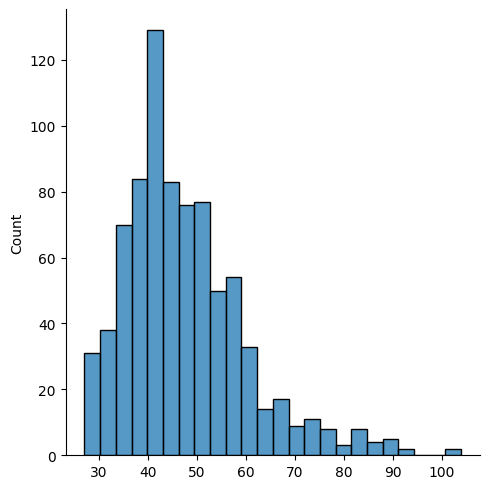

In [16]:
# how long is our training data?
doc_lengths = []
for triplet in triplets:
    tokens = nltk.word_tokenize(triplet)
    doc_lengths.append(len(tokens))
doc_lengths = np.asarray(doc_lengths)
sns.displot(doc_lengths)

In [17]:
np.average(doc_lengths)
# on average, we have ~47.5 tokens per entry, a good thing for GPT2 embedding size of 768 in gpt-small

47.53465346534654

In [18]:
model_name = config_dict['model_name']
hyperparameters = config_dict['training_settings']['hyperparameters']

In [19]:
model_name

'gpt2-medium'

In [20]:
# load gpt-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

In [21]:
tokenizer.pad_token = tokenizer.eos_token

In [22]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|endoftext|> token has the id 50256
The end of sequence token <|endoftext|> has the id 50256
The padding token <|endoftext|> has the id 50256


In [23]:
raw_datasets = load_dataset('csv', data_files=config_dict['data_train_path'])
raw_datasets["validation"] = (load_dataset('csv', data_files=config_dict['data_validation_path']))["train"]
print(raw_datasets)

Using custom data configuration default-9f66f072da4e52b1
Found cached dataset csv (/home/ubuntu/.cache/huggingface/datasets/csv/default-9f66f072da4e52b1/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 662.40it/s]
Using custom data configuration default-c257cc22185509a4
Found cached dataset csv (/home/ubuntu/.cache/huggingface/datasets/csv/default-c257cc22185509a4/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 849.57it/s]

DatasetDict({
    train: Dataset({
        features: ['triplet'],
        num_rows: 808
    })
    validation: Dataset({
        features: ['triplet'],
        num_rows: 95
    })
})


In [24]:
for key in raw_datasets["train"][0]:
    print(f"{key.upper()}: {raw_datasets['train'][0][key][:256]}")

TRIPLET: Prompt: Now, what is the thing you like least about smoking?
Response: The medical risks
Reflection: You are aware of the medical risks of smoking and you worry about what might happen if you do not quit.



In [25]:
#helper for tokenizing everything
def tokenize_function(examples):
    return tokenizer(examples["triplet"], truncation=True)

In [26]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/csv/default-9f66f072da4e52b1/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-1892bd87a0f2b54e.arrow
100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.33ba/s]


In [27]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['triplet', 'input_ids', 'attention_mask'],
        num_rows: 808
    })
    validation: Dataset({
        features: ['triplet', 'input_ids', 'attention_mask'],
        num_rows: 95
    })
})

In [28]:
tokenized_datasets = tokenized_datasets.remove_columns(["triplet"])

In [29]:
# amount of examples passed through model before a backwards pass
batch_size = hyperparameters['batch_size']

In [30]:
# config to instantiate model
configuration = GPT2Config.from_pretrained(model_name, output_hidden_states=False)


In [31]:
# instantiate model
model = GPT2LMHeadModel.from_pretrained(model_name, config=configuration)


In [32]:
# resize token embeddings for our custom tokens (e.g. bos_token)
model.resize_token_embeddings(len(tokenizer))

Embedding(50257, 1024)

In [33]:
device = torch.device("cuda")

In [34]:
# sends model to current device - in this case CUDA
model.cuda()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout)

In [36]:
# Set the seed value
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [37]:
# all the below set the corresponding values from the configuration file config.yaml:
model_name = config_dict["model_name"]
pretrained = config_dict["pretrained"]
data_train_path = config_dict["data_train_path"]
data_validation_path = config_dict["data_validation_path"]


output_data_dir = config_dict["output_data_dir"] + "/"
output_model_dir = config_dict["output_model_dir"] + "/"

hyperparameters = config_dict["training_settings"]["hyperparameters"]
hyperparameters["learning_rate"] = float(hyperparameters["learning_rate"])
hyperparameters["weight_decay"] = float(hyperparameters["weight_decay"])

deepspeed_config = config_dict["training_settings"]["deepspeed_settings"]

In [38]:
hyperparameters

{'find_hyperparams_automatically': False,
 'num_trials': 10,
 'fp16': True,
 'deepspeed': True,
 'grad_accumulation_steps': 2,
 'eval_batch_size': 1,
 'learning_rate': 0.0003,
 'epochs': 10,
 'warmup_steps': 100,
 'epsilon': '1e-7',
 'batch_size': 1,
 'sample_every': 100,
 'seed': 42,
 'eval_steps': 10,
 'weight_decay': 0.01}

In [39]:
learning_rate = hyperparameters['learning_rate']
epsilon = float(hyperparameters['epsilon'])  # epsilon must be a float, not str
epochs = hyperparameters['epochs']
warmup_steps = float(hyperparameters['warmup_steps'])
sample_every = float(hyperparameters['sample_every'])

In [40]:
# For gradient checkpointing, use HF training
# I tried custom gradient checkpointing, but am getting issues with HF ecosystem + pytorch checkpointing
# HF repository https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py
# shows gradient checkpointing method, later i'll try pytorch lightning



training_args = TrainingArguments(output_dir=config_dict['output_model_dir'],
                                overwrite_output_dir=True,
                                fp16 = config_dict['training_settings']['hyperparameters']["fp16"],
                                #deepspeed=config_dict['training_settings']['deepspeed_settings'],
                                evaluation_strategy = "steps", # used to be epoch
                                prediction_loss_only = True, #get rid of this if we end up adding metrics
                                logging_dir=f"./logs/",
                                logging_strategy="steps",
                                logging_steps=5,
                                save_strategy="no",
                                per_device_eval_batch_size=config_dict['training_settings']['hyperparameters']["eval_batch_size"],
                                gradient_accumulation_steps=config_dict['training_settings']['hyperparameters']["grad_accumulation_steps"],
                                learning_rate=config_dict['training_settings']['hyperparameters']["learning_rate"],
                                weight_decay=config_dict['training_settings']['hyperparameters']["weight_decay"],
                                num_train_epochs=config_dict['training_settings']['hyperparameters']["epochs"],
                                seed=config_dict['training_settings']['hyperparameters']["seed"],
                                per_device_train_batch_size=config_dict['training_settings']['hyperparameters']["batch_size"],
                                eval_steps=config_dict['training_settings']['hyperparameters']["eval_steps"]
                                )

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [41]:
# constructs the Trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    data_collator=DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False),
    tokenizer=tokenizer
)

Using cuda_amp half precision backend


In [ ]:
trainer.train() #training time

/home/ubuntu/anaconda3/envs/torch_p37/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 808
  Num Epochs = 10
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 2
  Total optimization steps = 4040
  Number of trainable parameters = 354823168


Step,Training Loss,Validation Loss
10,2.298400,1.911232
20,2.007600,1.723112
30,2.035900,1.634935
40,1.677200,1.605397
50,1.860800,1.475746
60,1.875200,1.570996
70,1.571100,1.442065
80,1.534400,1.453672
90,1.291500,1.449032
100,1.581500,1.488120


***** Running Evaluation *****
  Num examples = 95
  Batch size = 1
***** Running Evaluation *****
  Num examples = 95
  Batch size = 1
***** Running Evaluation *****
  Num examples = 95
  Batch size = 1
***** Running Evaluation *****
  Num examples = 95
  Batch size = 1
***** Running Evaluation *****
  Num examples = 95
  Batch size = 1
***** Running Evaluation *****
  Num examples = 95
  Batch size = 1
***** Running Evaluation *****
  Num examples = 95
  Batch size = 1
***** Running Evaluation *****
  Num examples = 95
  Batch size = 1
***** Running Evaluation *****
  Num examples = 95
  Batch size = 1
***** Running Evaluation *****
  Num examples = 95
  Batch size = 1
***** Running Evaluation *****
  Num examples = 95
  Batch size = 1
***** Running Evaluation *****
  Num examples = 95
  Batch size = 1
***** Running Evaluation *****
  Num examples = 95
  Batch size = 1
***** Running Evaluation *****
  Num examples = 95
  Batch size = 1
***** Running Evaluation *****
  Num examples = 

In [ ]:
#Save Results 
trainer.save_model(self.output_model_dir) 